In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import scale

from keras.models import Sequential
from keras.layers import Dense, Dropout

from keras.layers.normalization import BatchNormalization
from keras.initializers import Initializer
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model


Using TensorFlow backend.


In [2]:
raw_data = pd.read_csv('./data/ordered_molecules.csv')

In [3]:
raw_data = raw_data.loc[(raw_data['time'] >= 0) & (raw_data['time'] <= 500)]

In [4]:
raw_data.head()

,time,molecule,px,py,pz,ax,ay,az
0,0,1,0.27497,0.22765,0.40548,1.185458,-1.527830,-4.614324
1,0,2,2.13410,1.61428,1.62211,-4.601109,-0.659241,1.090967
2,0,3,12.05408,12.60878,2.90295,4.530882,-2.598597,2.008448
3,0,4,0.85376,1.93829,4.87515,3.975239,0.917088,-2.261618
4,0,5,12.70257,0.12956,6.09076,-1.861295,-0.908830,5.337542


In [5]:
#raw_data.iloc[:,2:] = scale(raw_data.iloc[:,2:], axis = 0)

In [6]:
raw_data_scaled = raw_data

In [8]:
target_data = raw_data_scaled.iloc[128:,2:]
data = pd.concat([raw_data_scaled.iloc[0:64000,:].reset_index(drop=True), target_data.reset_index(drop=True)], axis = 1, ignore_index=True)

In [9]:
data.shape

(64000, 14)

In [10]:
diff_x = data.iloc[:,8] - data.iloc[:,2]
diff_y = data.iloc[:,9] - data.iloc[:,3]
diff_z = data.iloc[:,10] - data.iloc[:,4]


diff_x_idx, = np.where(abs(diff_x) > 3)
diff_y_idx, = np.where(abs(diff_y) > 3)
diff_z_idx, = np.where(abs(diff_z) > 3)

diff_idx = set(diff_x_idx) | set(diff_y_idx) | set(diff_z_idx)

final_data = data.loc[data.index.drop(list(diff_idx))]

In [11]:
x_train, x_test, y_train, y_test = train_test_split(final_data.iloc[:,2:8], 
                                                    final_data.iloc[:,8:], 
                                                    test_size = 0.3, random_state = 10)

In [12]:
#model 1
model_1 = Sequential()

model_1.add(Dense(32, input_dim=6, activation='relu', kernel_initializer = 'he_normal', kernel_regularizer = regularizers.l2(0.01)))
model_1.add(BatchNormalization())

model_1.add(Dense(32, activation='relu', kernel_initializer = 'he_normal', kernel_regularizer = regularizers.l2(0.01)))
model_1.add(BatchNormalization())

model_1.add(Dense(32, activation='relu', kernel_initializer = 'he_normal', kernel_regularizer = regularizers.l2(0.01)))
model_1.add(BatchNormalization())

model_1.add(Dense(6, activation='linear', kernel_initializer = 'glorot_normal', kernel_regularizer = regularizers.l2(0.01)))

In [13]:
model_1.compile(loss='mean_absolute_error', optimizer= "rmsprop", metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=20, mode='min')
model_check_point = ModelCheckpoint('./model/DNN_BN_test.h5', monitor = 'val_loss', verbose=2, save_best_only=True)
callback_list = [model_check_point, early_stop]

In [14]:
hist_1 = model_1.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=150, batch_size=64, callbacks = callback_list)

Train on 44729 samples, validate on 19170 samples
Epoch 1/150
44729/44729 [==============================] - 3s 73us/step - loss: 2.5858 - mean_absolute_error: 1.7110 - val_loss: 1.0879 - val_mean_absolute_error: 0.4703

Epoch 00001: val_loss improved from inf to 1.08791, saving model to ./model/DNN_BN_test.h5
Epoch 2/150
44729/44729 [==============================] - 2s 46us/step - loss: 0.9878 - mean_absolute_error: 0.5053 - val_loss: 0.8418 - val_mean_absolute_error: 0.4604

Epoch 00002: val_loss improved from 1.08791 to 0.84185, saving model to ./model/DNN_BN_test.h5
Epoch 3/150
44729/44729 [==============================] - 2s 45us/step - loss: 0.7996 - mean_absolute_error: 0.4756 - val_loss: 0.6687 - val_mean_absolute_error: 0.3920

Epoch 00003: val_loss improved from 0.84185 to 0.66868, saving model to ./model/DNN_BN_test.h5
Epoch 4/150
44729/44729 [==============================] - 2s 45us/step - loss: 0.7132 - mean_absolute_error: 0.4663 - val_loss: 0.5615 - val_mean_absolute_

In [15]:
model = load_model('./model/DNN_BN_test.h5')

In [16]:
y_pred = model.predict(x_test)

In [17]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae_metric = mean_absolute_error(y_test, y_pred)
r2_error = r2_score(y_test, y_pred)

In [18]:
print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae_metric)
print("R2_Score:", r2_error)

MSE:  0.03229488910229244
RMSE:  0.17970778809582083
MAE:  0.13599438011177734
R2_Score: 0.996475055060278


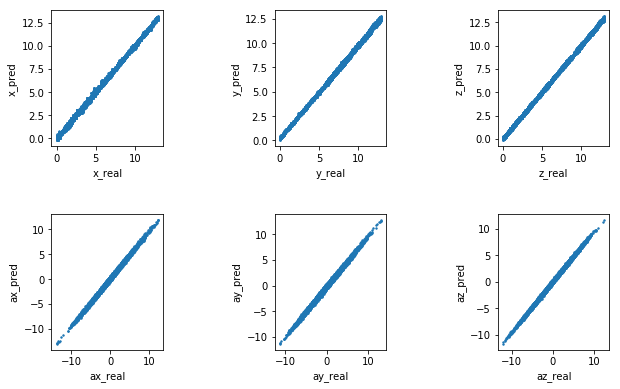

In [19]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(3,3,1)
ax2 = fig.add_subplot(3,3,2)
ax3 = fig.add_subplot(3,3,3)
ax4 = fig.add_subplot(3,3,4)
ax5 = fig.add_subplot(3,3,5)
ax6 = fig.add_subplot(3,3,6)

ax1.scatter(y_test.values[:,0], y_pred[:,0], s= 2)
ax1.set_xlabel('x_real')
ax1.set_ylabel('x_pred')
ax2.scatter(y_test.values[:,1], y_pred[:,1], s= 2)
ax2.set_xlabel('y_real')
ax2.set_ylabel('y_pred')
ax3.scatter(y_test.values[:,2], y_pred[:,2], s= 2)
ax3.set_xlabel('z_real')
ax3.set_ylabel('z_pred')
ax4.scatter(y_test.values[:,3], y_pred[:,3], s= 2)
ax4.set_xlabel('ax_real')
ax4.set_ylabel('ax_pred')
ax5.scatter(y_test.values[:,4], y_pred[:,4], s= 2)
ax5.set_xlabel('ay_real')
ax5.set_ylabel('ay_pred')
ax6.scatter(y_test.values[:,5], y_pred[:,5], s= 2)
ax6.set_xlabel('az_real')
ax6.set_ylabel('az_pred')

plt.subplots_adjust(wspace = 1, hspace = 0.5)
plt.show()

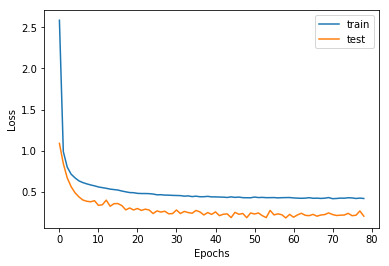

In [20]:
# plot history
plt.plot(hist_1.history['loss'], label='train')
plt.plot(hist_1.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
#cross validation

kfold = KFold(n_splits=20, shuffle=True, random_state = 500)
X = final_data.iloc[:,2:8]
Y = final_data.iloc[:,8:]

cv_rmse = []
cv_mae = []
cv_r2 = []

for train, test in kfold.split(X, Y):
    
    # evaluate the model
    pred = model.predict(X.iloc[test,:])
    
    rmse = np.sqrt(mean_squared_error(Y.iloc[test,:], pred))
    mae = mean_absolute_error(Y.iloc[test,:], pred)
    r2 = r2_score(Y.iloc[test,:], pred)
    
    cv_rmse.append(rmse)
    cv_mae.append(mae)
    cv_r2.append(r2)

In [22]:
print(np.mean(cv_rmse))
print(np.std(cv_rmse))
print('\n')

print(np.mean(cv_mae))
print(np.std(cv_mae))
print('\n')

print(np.mean(cv_r2))
print(np.std(cv_r2))

0.1797943933782195
0.0010100250896837673


0.13613905834436518
0.0007352497563814413


0.9964706164701932
5.220469730872192e-05


In [30]:
###############################################################################

원래 scale 로 변환

In [31]:
raw_data = pd.read_csv('./data/ordered_molecules.csv')

In [32]:
px_mean = np.mean(raw_data['px'])
px_std = np.std(raw_data['px'])
py_mean = np.mean(raw_data['py'])
py_std = np.std(raw_data['py'])
pz_mean = np.mean(raw_data['pz'])
pz_std = np.std(raw_data['pz'])

ax_mean = np.mean(raw_data['ax'])
ax_std = np.std(raw_data['ax'])
ay_mean = np.mean(raw_data['ay'])
ay_std = np.std(raw_data['ay'])
az_mean = np.mean(raw_data['az'])
az_std = np.std(raw_data['az'])

In [33]:
y_test.iloc[:,0] = y_test.iloc[:,0] * px_std + px_mean
y_test.iloc[:,1] = y_test.iloc[:,1] * py_std + py_mean
y_test.iloc[:,2] = y_test.iloc[:,2] * pz_std + pz_mean

y_test.iloc[:,3] = y_test.iloc[:,3] * ax_std + ax_mean
y_test.iloc[:,4] = y_test.iloc[:,4] * ay_std + ay_mean
y_test.iloc[:,5] = y_test.iloc[:,5] * az_std + az_mean


In [34]:
y_pred_df = pd.DataFrame(y_pred)

In [35]:
y_pred_df.iloc[:,0] = y_pred_df.iloc[:,0] * px_std + px_mean
y_pred_df.iloc[:,1] = y_pred_df.iloc[:,1] * py_std + py_mean
y_pred_df.iloc[:,2] = y_pred_df.iloc[:,2] * pz_std + pz_mean

y_pred_df.iloc[:,3] = y_pred_df.iloc[:,3] * ax_std + ax_mean
y_pred_df.iloc[:,4] = y_pred_df.iloc[:,4] * ay_std + ay_mean
y_pred_df.iloc[:,5] = y_pred_df.iloc[:,5] * az_std + az_mean

In [36]:
mse = mean_squared_error(y_test, y_pred_df)
rmse = np.sqrt(mse)
mae_metric = mean_absolute_error(y_test, y_pred_df)
r2_error = r2_score(y_test, y_pred_df)

In [37]:
print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae_metric)
print("R2_Score:", r2_error)

MSE:  0.046369350713990405
RMSE:  0.2153354376641021
MAE:  0.15791820639455167
R2_Score: 0.9945541084578083


In [38]:
#cross validation

kfold = KFold(n_splits=20, shuffle=True, random_state = 500)
X = final_data.iloc[:,2:8]
Y = final_data.iloc[:,8:]

cv_rmse = []
cv_mae = []
cv_r2 = []

for train, test in kfold.split(X, Y):
    y_test = Y.iloc[test,:]

    y_test.iloc[:,0] = y_test.iloc[:,0] * px_std + px_mean
    y_test.iloc[:,1] = y_test.iloc[:,1] * py_std + py_mean
    y_test.iloc[:,2] = y_test.iloc[:,2] * pz_std + pz_mean

    y_test.iloc[:,3] = y_test.iloc[:,3] * ax_std + ax_mean
    y_test.iloc[:,4] = y_test.iloc[:,4] * ay_std + ay_mean
    y_test.iloc[:,5] = y_test.iloc[:,5] * az_std + az_mean
    
    y_pred = model.predict(X.iloc[test,:])
    y_pred_df = pd.DataFrame(y_pred)
    
    y_pred_df.iloc[:,0] = y_pred_df.iloc[:,0] * px_std + px_mean
    y_pred_df.iloc[:,1] = y_pred_df.iloc[:,1] * py_std + py_mean
    y_pred_df.iloc[:,2] = y_pred_df.iloc[:,2] * pz_std + pz_mean

    y_pred_df.iloc[:,3] = y_pred_df.iloc[:,3] * ax_std + ax_mean
    y_pred_df.iloc[:,4] = y_pred_df.iloc[:,4] * ay_std + ay_mean
    y_pred_df.iloc[:,5] = y_pred_df.iloc[:,5] * az_std + az_mean
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_df))
    mae = mean_absolute_error(y_test, y_pred_df)
    r2 = r2_score(y_test, y_pred_df)
    
    cv_rmse.append(rmse)
    cv_mae.append(mae)
    cv_r2.append(r2)

/usr/local/anaconda/envs/env_py3/lib/python3.6/site-packages/pandas/core/indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [39]:
print(np.mean(cv_rmse))
print(np.std(cv_rmse))
print('\n')

print(np.mean(cv_mae))
print(np.std(cv_mae))
print('\n')

print(np.mean(cv_r2))
print(np.std(cv_r2))

0.2150729214100356
0.0033220475426071596


0.157912338189241
0.0010395283807248447


0.9945696091137004
0.00016215912410976765


In [23]:
raw_data = pd.read_csv('./data/ordered_molecules.csv')

In [24]:
#raw_data.iloc[:,2:] = scale(raw_data.iloc[:,2:], axis = 0)

raw_data_scaled = raw_data

In [25]:
raw_data_scaled.head()

,time,molecule,px,py,pz,ax,ay,az
0,0,1,0.27497,0.22765,0.40548,1.185458,-1.527830,-4.614324
1,0,2,2.13410,1.61428,1.62211,-4.601109,-0.659241,1.090967
2,0,3,12.05408,12.60878,2.90295,4.530882,-2.598597,2.008448
3,0,4,0.85376,1.93829,4.87515,3.975239,0.917088,-2.261618
4,0,5,12.70257,0.12956,6.09076,-1.861295,-0.908830,5.337542


In [26]:
test_data = raw_data_scaled.loc[(raw_data_scaled['time'] >= 501) & (raw_data_scaled['time'] <= 600)]

In [27]:
test_data.tail()

,time,molecule,px,py,pz,ax,ay,az
76923,600,124,11.87236,11.60171,5.39335,-0.500328,-2.837816,1.611168
76924,600,125,8.39364,8.45403,5.90487,4.020507,-5.413309,1.877294
76925,600,126,1.52384,12.15480,8.03993,-0.262397,-0.228747,-1.178070
76926,600,127,10.48536,9.15239,8.98852,-3.601060,-1.924487,2.913010
76927,600,128,9.72046,12.32493,10.94059,-0.394199,-0.266843,-4.200470


In [28]:
predicted = model.predict(test_data.iloc[:,2:])

In [29]:
predicted

array([[ 7.2866321e-01,  1.0811494e+01,  1.1416976e+01,  4.5848709e-01,
        -2.0757062e+00,  3.2427971e+00],
       [ 1.0059953e-02,  1.4712685e+00,  1.0425003e+00,  3.1728921e+00,
         1.0124816e+00,  5.2346764e+00],
       [-2.1099210e-02,  1.2493051e+01,  3.7425680e+00, -6.9305938e-01,
        -3.0629784e-01, -1.3606467e+00],
       ...,
       [ 1.5475361e+00,  1.1897922e+01,  8.1056585e+00, -2.8503361e-01,
        -5.0551414e-01, -1.0235683e+00],
       [ 1.0526325e+01,  8.9984884e+00,  9.1338863e+00, -3.3923454e+00,
        -2.1133232e+00,  2.7826743e+00],
       [ 9.8302822e+00,  1.2180186e+01,  1.1142347e+01, -2.0966202e-01,
        -4.3414158e-01, -3.9584534e+00]], dtype=float32)

In [30]:
next_data = raw_data_scaled.loc[(raw_data_scaled['time'] >= 502) & (raw_data_scaled['time'] <= 601)]

In [33]:
print(mean_squared_error(next_data.iloc[:,2:], pd.DataFrame(predicted)))
print(mean_absolute_error(next_data.iloc[:,2:], pd.DataFrame(predicted)))
print(r2_score(next_data.iloc[:,2:], pd.DataFrame(predicted)))

0.06464983774353855
0.14024119912169605
0.9940541021910986


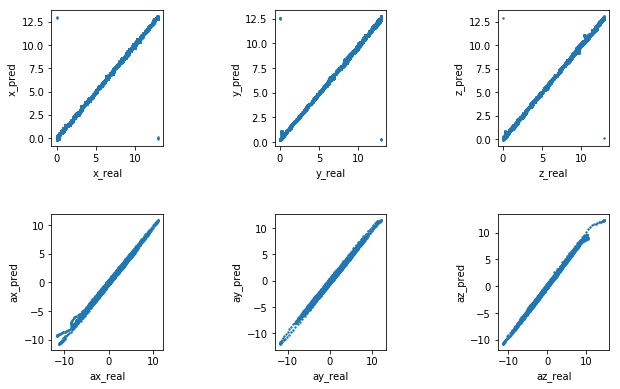

In [32]:
fig_2 = plt.figure(figsize=(10,10))

ax1 = fig_2.add_subplot(3,3,1)
ax2 = fig_2.add_subplot(3,3,2)
ax3 = fig_2.add_subplot(3,3,3)
ax4 = fig_2.add_subplot(3,3,4)
ax5 = fig_2.add_subplot(3,3,5)
ax6 = fig_2.add_subplot(3,3,6)

ax1.scatter(next_data.iloc[:,2], pd.DataFrame(predicted).iloc[:,0], s= 2)
ax1.set_xlabel('x_real')
ax1.set_ylabel('x_pred')
#ax1.set_xlim((-2.5, 2.5))
#ax1.set_ylim((-2.5, 2.5))
ax2.scatter(next_data.iloc[:,3], pd.DataFrame(predicted).iloc[:,1], s= 2)
ax2.set_xlabel('y_real')
ax2.set_ylabel('y_pred')
#ax2.set_xlim((-2.5, 2.5))
#ax2.set_ylim((-2.5, 2.5))
ax3.scatter(next_data.iloc[:,4], pd.DataFrame(predicted).iloc[:,2], s= 2)
ax3.set_xlabel('z_real')
ax3.set_ylabel('z_pred')
#ax3.set_xlim((-2.5, 2.5))
#ax3.set_ylim((-2.5, 2.5))
ax4.scatter(next_data.iloc[:,5], pd.DataFrame(predicted).iloc[:,3], s= 2)
ax4.set_xlabel('ax_real')
ax4.set_ylabel('ax_pred')
#ax4.set_xlim((-2.5, 2.5))
#ax4.set_ylim((-2.5, 2.5))
ax5.scatter(next_data.iloc[:,6], pd.DataFrame(predicted).iloc[:,4], s= 2)
ax5.set_xlabel('ay_real')
ax5.set_ylabel('ay_pred')
#ax5.set_xlim((-2.5, 2.5))
#ax5.set_ylim((-2.5, 2.5))
ax6.scatter(next_data.iloc[:,7], pd.DataFrame(predicted).iloc[:,5], s= 2)
ax6.set_xlabel('az_real')
ax6.set_ylabel('az_pred')
#ax6.set_xlim((-2.5, 2.5))
#ax6.set_ylim((-2.5, 2.5))

plt.subplots_adjust(wspace = 1, hspace = 0.5)
plt.show()

In [61]:
px_mean = np.mean(test_data['px'])
px_std = np.std(test_data['px'])
py_mean = np.mean(test_data['py'])
py_std = np.std(test_data['py'])
pz_mean = np.mean(test_data['pz'])
pz_std = np.std(test_data['pz'])

ax_mean = np.mean(test_data['ax'])
ax_std = np.std(test_data['ax'])
ay_mean = np.mean(test_data['ay'])
ay_std = np.std(test_data['ay'])
az_mean = np.mean(test_data['az'])
az_std = np.std(test_data['az'])

In [74]:
np.std(test_data['px'])

0.9861126513748661

In [75]:
np.std(next_data['px'])

0.9860718614904698

In [67]:
a = next_data.iloc[:,2] * px_std + px_mean
b = next_data.iloc[:,3] * py_std + py_mean
c = next_data.iloc[:,4] * pz_std + pz_mean

d= next_data.iloc[:,5] * ax_std + ax_mean
e = next_data.iloc[:,6] * ay_std + ay_mean
f = next_data.iloc[:,7] * az_std + az_mean


In [68]:
all_df = pd.concat([a.reset_index(drop=True),b.reset_index(drop=True),c.reset_index(drop=True),d.reset_index(drop=True),e.reset_index(drop=True),f.reset_index(drop=True)],axis=1)

In [69]:
all_df.head()

,px,py,pz,ax,ay,az
0,-1.511712,1.088998,1.205650,0.319540,-0.593479,1.168112
1,-1.663488,-1.480897,-1.404258,1.465105,0.429115,1.896755
2,-1.667576,1.588766,-0.777714,-0.326174,-0.032933,-0.563683
3,-0.816014,-1.205403,0.193939,0.298583,-1.756449,-2.191349
4,-1.340106,-1.630175,-0.278171,1.473514,-1.096934,0.133657


In [55]:
pd.DataFrame(predicted).iloc[:,0] = pd.DataFrame(predicted).iloc[:,0] * px_std + px_mean
pd.DataFrame(predicted).iloc[:,1] = pd.DataFrame(predicted).iloc[:,1] * py_std + py_mean
pd.DataFrame(predicted).iloc[:,2] = pd.DataFrame(predicted).iloc[:,2] * pz_std + pz_mean

pd.DataFrame(predicted).iloc[:,3] = pd.DataFrame(predicted).iloc[:,3] * ax_std + ax_mean
pd.DataFrame(predicted).iloc[:,4] = pd.DataFrame(predicted).iloc[:,4] * ay_std + ay_mean
pd.DataFrame(predicted).iloc[:,5] = pd.DataFrame(predicted).iloc[:,5] * az_std + az_mean

In [56]:
mean_absolute_error(next_data.iloc[:,2:], pd.DataFrame(predicted))

0.05545773101016804

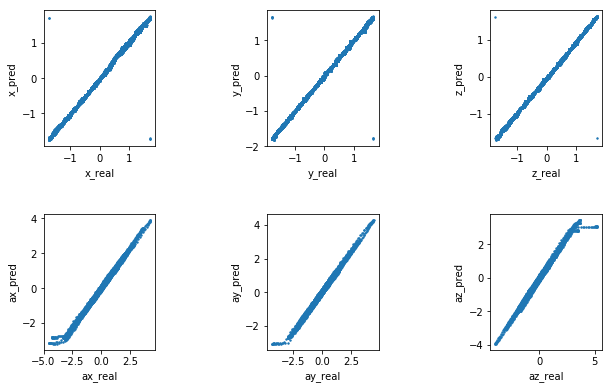

In [57]:
fig_3 = plt.figure(figsize=(10,10))

ax1 = fig_3.add_subplot(3,3,1)
ax2 = fig_3.add_subplot(3,3,2)
ax3 = fig_3.add_subplot(3,3,3)
ax4 = fig_3.add_subplot(3,3,4)
ax5 = fig_3.add_subplot(3,3,5)
ax6 = fig_3.add_subplot(3,3,6)

ax1.scatter(next_data.iloc[:,2], pd.DataFrame(predicted).iloc[:,0], s= 2)
ax1.set_xlabel('x_real')
ax1.set_ylabel('x_pred')
#ax1.set_xlim((-2.5, 2.5))
#ax1.set_ylim((-2.5, 2.5))
ax2.scatter(next_data.iloc[:,3], pd.DataFrame(predicted).iloc[:,1], s= 2)
ax2.set_xlabel('y_real')
ax2.set_ylabel('y_pred')
#ax2.set_xlim((-2.5, 2.5))
#ax2.set_ylim((-2.5, 2.5))
ax3.scatter(next_data.iloc[:,4], pd.DataFrame(predicted).iloc[:,2], s= 2)
ax3.set_xlabel('z_real')
ax3.set_ylabel('z_pred')
#ax3.set_xlim((-2.5, 2.5))
#ax3.set_ylim((-2.5, 2.5))
ax4.scatter(next_data.iloc[:,5], pd.DataFrame(predicted).iloc[:,3], s= 2)
ax4.set_xlabel('ax_real')
ax4.set_ylabel('ax_pred')
#ax4.set_xlim((-2.5, 2.5))
#ax4.set_ylim((-2.5, 2.5))
ax5.scatter(next_data.iloc[:,6], pd.DataFrame(predicted).iloc[:,4], s= 2)
ax5.set_xlabel('ay_real')
ax5.set_ylabel('ay_pred')
#ax5.set_xlim((-2.5, 2.5))
#ax5.set_ylim((-2.5, 2.5))
ax6.scatter(next_data.iloc[:,7], pd.DataFrame(predicted).iloc[:,5], s= 2)
ax6.set_xlabel('az_real')
ax6.set_ylabel('az_pred')
#ax6.set_xlim((-2.5, 2.5))
#ax6.set_ylim((-2.5, 2.5))

plt.subplots_adjust(wspace = 1, hspace = 0.5)
plt.show()